In [5]:
# !pip install --user git+https://github.com/gaarangoa/METk.git

In [10]:
%load_ext autoreload
%autoreload 2
# ------------
import numpy as np
import pandas as pd
import sys, os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import glob
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, classification_report

from metaCH.src.feature_extraction.extract_features import extract_features
from metaCH.src.classification.inference import inference

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Tumor somatic prediction (GENIE)

In [2]:
# Create output directory if it doesn't exist
os.makedirs('/data/genie_v17.0/mutation', exist_ok=True)

# Read the large file
df = pd.read_csv('/data/genie_v17.0/data_mutations_extended.txt', sep='\t')
df = df[df['Chromosome'] != 'MT']

# Split into 10 approximately equal parts
n_splits = 30
dfs = np.array_split(df, n_splits)

# Save each part to a separate file
for i, split_df in enumerate(dfs, 1):
    output_file = f'/data/genie_v17.0/mutation/mutations_part_{i:02d}.txt'
    split_df.to_csv(output_file, sep='\t', index=False)
    print(f"Saved {len(split_df)} rows to {output_file}")

print(f"\nTotal rows: {len(df)}")
print(f"Files created: {n_splits}")

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (4,12,17,18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Saved 75434 rows to /data/genie_v17.0/mutation/mutations_part_01.txt
Saved 75434 rows to /data/genie_v17.0/mutation/mutations_part_02.txt
Saved 75434 rows to /data/genie_v17.0/mutation/mutations_part_03.txt
Saved 75434 rows to /data/genie_v17.0/mutation/mutations_part_04.txt
Saved 75434 rows to /data/genie_v17.0/mutation/mutations_part_05.txt
Saved 75434 rows to /data/genie_v17.0/mutation/mutations_part_06.txt
Saved 75434 rows to /data/genie_v17.0/mutation/mutations_part_07.txt
Saved 75434 rows to /data/genie_v17.0/mutation/mutations_part_08.txt
Saved 75434 rows to /data/genie_v17.0/mutation/mutations_part_09.txt
Saved 75434 rows to /data/genie_v17.0/mutation/mutations_part_10.txt
Saved 75434 rows to /data/genie_v17.0/mutation/mutations_part_11.txt
Saved 75434 rows to /data/genie_v17.0/mutation/mutations_part_12.txt
Saved 75434 rows to /data/genie_v17.0/mutation/mutations_part_13.txt
Saved 75434 rows to /data/genie_v17.0/mutation/mutations_part_14.txt
Saved 75434 rows to /data/genie_v1

In [16]:
data_sample = pd.read_csv('/data/genie_v17.0/data_clinical_sample.txt', sep='\t', comment='#')
for i in range(28, n_splits+1):
    example_cfDNA_input = pd.read_csv(f'/data/genie_v17.0/mutation/mutations_part_{i:02d}.txt', sep='\t')
    example_cfDNA_input = example_cfDNA_input.rename(columns={'NCBI_Build': 'Reference_Genome',
                                                              'Tumor_Seq_Allele1': 'Tumor_Allele_1',
                                                              'Tumor_Seq_Allele2': 'Tumor_Allele_2',
                                                              'Tumor_Sample_Barcode': 'SAMPLE_ID'})
    example_cfDNA_input = pd.merge(example_cfDNA_input, data_sample[['SAMPLE_ID', 'CANCER_TYPE']], on='SAMPLE_ID', how='left')
    example_cfDNA_input = example_cfDNA_input.rename(columns={'SAMPLE_ID': 'Sample_ID'})
    example_cfDNA_input['Gene_Name'] = example_cfDNA_input['Hugo_Symbol']
    example_cfDNA_input['VAF'] = example_cfDNA_input['t_alt_count'] / (example_cfDNA_input['t_alt_count'] + example_cfDNA_input['t_ref_count'])
    example_cfDNA_input = example_cfDNA_input[~np.isinf(example_cfDNA_input['VAF'])]
    example_cfDNA_input = example_cfDNA_input[['Chromosome', 'Start_Position', 'End_Position','Reference_Allele','Tumor_Allele_1','Tumor_Allele_2', 'Variant_Type','Hugo_Symbol','Gene_Name','Reference_Genome','VAF','CANCER_TYPE','Sample_ID']].dropna()
    if len(example_cfDNA_input) > 0:
        features = extract_features(example_cfDNA_input, 'paper')
        results = inference(features, 'paper')
        threshold=0.5
        results['prediction']=np.where(results['ch_score_meta'] > threshold, 'CHIP', 'TUMOR-SOMATIC')
        results['ground_truth'] = 'TUMOR-SOMATIC'
        results.to_csv(f"/METk/MetaCH/results/genie_results/genie_tumor_somatic_results_{i:02d}.csv", index=False)
    else:
        print(f'/data/genie_v17.0/mutation/mutations_part_{i:02d}.txt has no samples left after filtering!')

/data/genie_v17.0/mutation/mutations_part_28.txt has no samples left after filtering!
/data/genie_v17.0/mutation/mutations_part_29.txt has no samples left after filtering!
/data/genie_v17.0/mutation/mutations_part_30.txt has no samples left after filtering!


## CH prediction msk_ch_2023

In [55]:
# example_cfDNA_input=pd.read_csv('example_input.csv')
example_cfDNA_input = pd.read_csv('/data/msk_ch_2023/data_mutations.txt', sep='\t')

data_sample = pd.read_csv('/data/genie_v17.0/data_clinical_sample.txt', sep='\t', comment='#')
example_cfDNA_input = example_cfDNA_input.rename(columns={'NCBI_Build': 'Reference_Genome',
                                                          'Tumor_Seq_Allele1': 'Tumor_Allele_1',
                                                          'Tumor_Seq_Allele2': 'Tumor_Allele_2',
                                                          'Tumor_Sample_Barcode': 'SAMPLE_ID'})
example_cfDNA_input = pd.merge(example_cfDNA_input, data_sample[['SAMPLE_ID', 'CANCER_TYPE']], on='SAMPLE_ID', how='left')
example_cfDNA_input = example_cfDNA_input.rename(columns={'SAMPLE_ID': 'Sample_ID'})
example_cfDNA_input['Gene_Name'] = example_cfDNA_input['Hugo_Symbol']
example_cfDNA_input['VAF'] = example_cfDNA_input['t_alt_count'] / (example_cfDNA_input['t_alt_count'] + example_cfDNA_input['t_ref_count'])
example_cfDNA_input = example_cfDNA_input[~np.isinf(example_cfDNA_input['VAF'])]
# example_cfDNA_input = example_cfDNA_input[['Chromosome', 'Start_Position', 'End_Position','Reference_Allele','Tumor_Allele_1','Tumor_Allele_2', 'Variant_Type','Hugo_Symbol','Gene_Name','Reference_Genome','VAF','CANCER_TYPE','Sample_ID']].dropna()
features = extract_features(example_cfDNA_input, 'paper')
results = inference(features, 'paper')
threshold=0.5
results['prediction']=np.where(results['ch_score_meta'] > threshold, 'CHIP', 'TUMOR-SOMATIC')
results['ground_truth'] = 'CHIP'
results.to_csv("/METk/MetaCH/results/msk_ch_2023.csv")

/METk/METk/dgv2.cbioportal.128.e500.bin


IndexError: index 0 is out of bounds for axis 0 with size 0

## Performance analysis and Visualization

In [68]:
result1_subset = pd.read_csv("/METk/MetaCH/results/genie_somatic_mutation_report_subset_output.csv", index_col="SAMPLE_ID")
result2_subset = pd.read_csv("/METk/MetaCH/results/CH_mutation_report_subset_output.csv", index_col="SAMPLE_ID")
result1_subset = result1_subset.rename(columns={'SAMPLE_ID': 'Sample_ID'})
result2_subset = result2_subset.rename(columns={'SAMPLE_ID': 'Sample_ID'})

subset_ids = result1_subset.index.unique().tolist() + result2_subset.index.unique().tolist() 

In [71]:
# Load results
result1 = pd.read_csv("/METk/MetaCH/results/msk_ch_2023_results.csv", index_col="Sample_ID")
csv_files = glob.glob('/METk/MetaCH/results/genie_results/*.csv')
result2 = pd.concat([pd.read_csv(f, index_col="Sample_ID") for f in csv_files])

# # Subset
# result1 = result1[result1.index.isin(subset_ids)]
# result2 = result2[result2.index.isin(subset_ids)]


result1 = result1.groupby('Sample_ID').agg({
    'prediction': lambda x: x.mode()[0] if not x.mode().empty else x.iloc[0],
    'ground_truth': 'first'
}).reset_index()
result2 = result2.groupby('Sample_ID').agg({
    'prediction': lambda x: x.mode()[0] if not x.mode().empty else x.iloc[0],
    'ground_truth': 'first'
}).reset_index()

results = pd.concat([result1, result2]).reset_index()
categories = results.prediction.unique().tolist()

# Calculate accuracy
correct = (results['prediction'] == results['ground_truth']).sum()
total = len(results)
accuracy = correct / total * 100

print(f"\n--- Performance Summary ---")
print(f"Total samples: {total}")
print(f"Correct predictions: {correct}")
print(f"Accuracy: {accuracy:.2f}%")

# Per-class metrics
for status in categories:
    class_data = results[results['ground_truth'] == status]
    if len(class_data) > 0:
        class_correct = (class_data['prediction'] == status).sum()
        class_acc = class_correct / len(class_data) * 100
        print(f"{status} accuracy: {class_acc:.2f}% ({class_correct}/{len(class_data)})")

# Precision, Recall, F1
y_true = results['ground_truth']
y_pred = results['prediction']

print("\n--- Classification Report ---")
print(classification_report(y_true, y_pred, labels=categories))



--- Performance Summary ---
Total samples: 180441
Correct predictions: 173238
Accuracy: 96.01%
CHIP accuracy: 83.77% (13252/15820)
TUMOR-SOMATIC accuracy: 97.18% (159986/164621)

--- Classification Report ---
               precision    recall  f1-score   support

         CHIP       0.74      0.84      0.79     15820
TUMOR-SOMATIC       0.98      0.97      0.98    164621

     accuracy                           0.96    180441
    macro avg       0.86      0.90      0.88    180441
 weighted avg       0.96      0.96      0.96    180441




--- Confusion Matrix ---
                CHIP  TUMOR-SOMATIC
CHIP           13252           2568
TUMOR-SOMATIC   4635         159986
locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7fff8027cf28>
Using auto colorbar locator <matplotlib.colorbar._ColorbarAutoLocator object at 0x7fff8027cf28> on colorbar
Setting pcolormesh


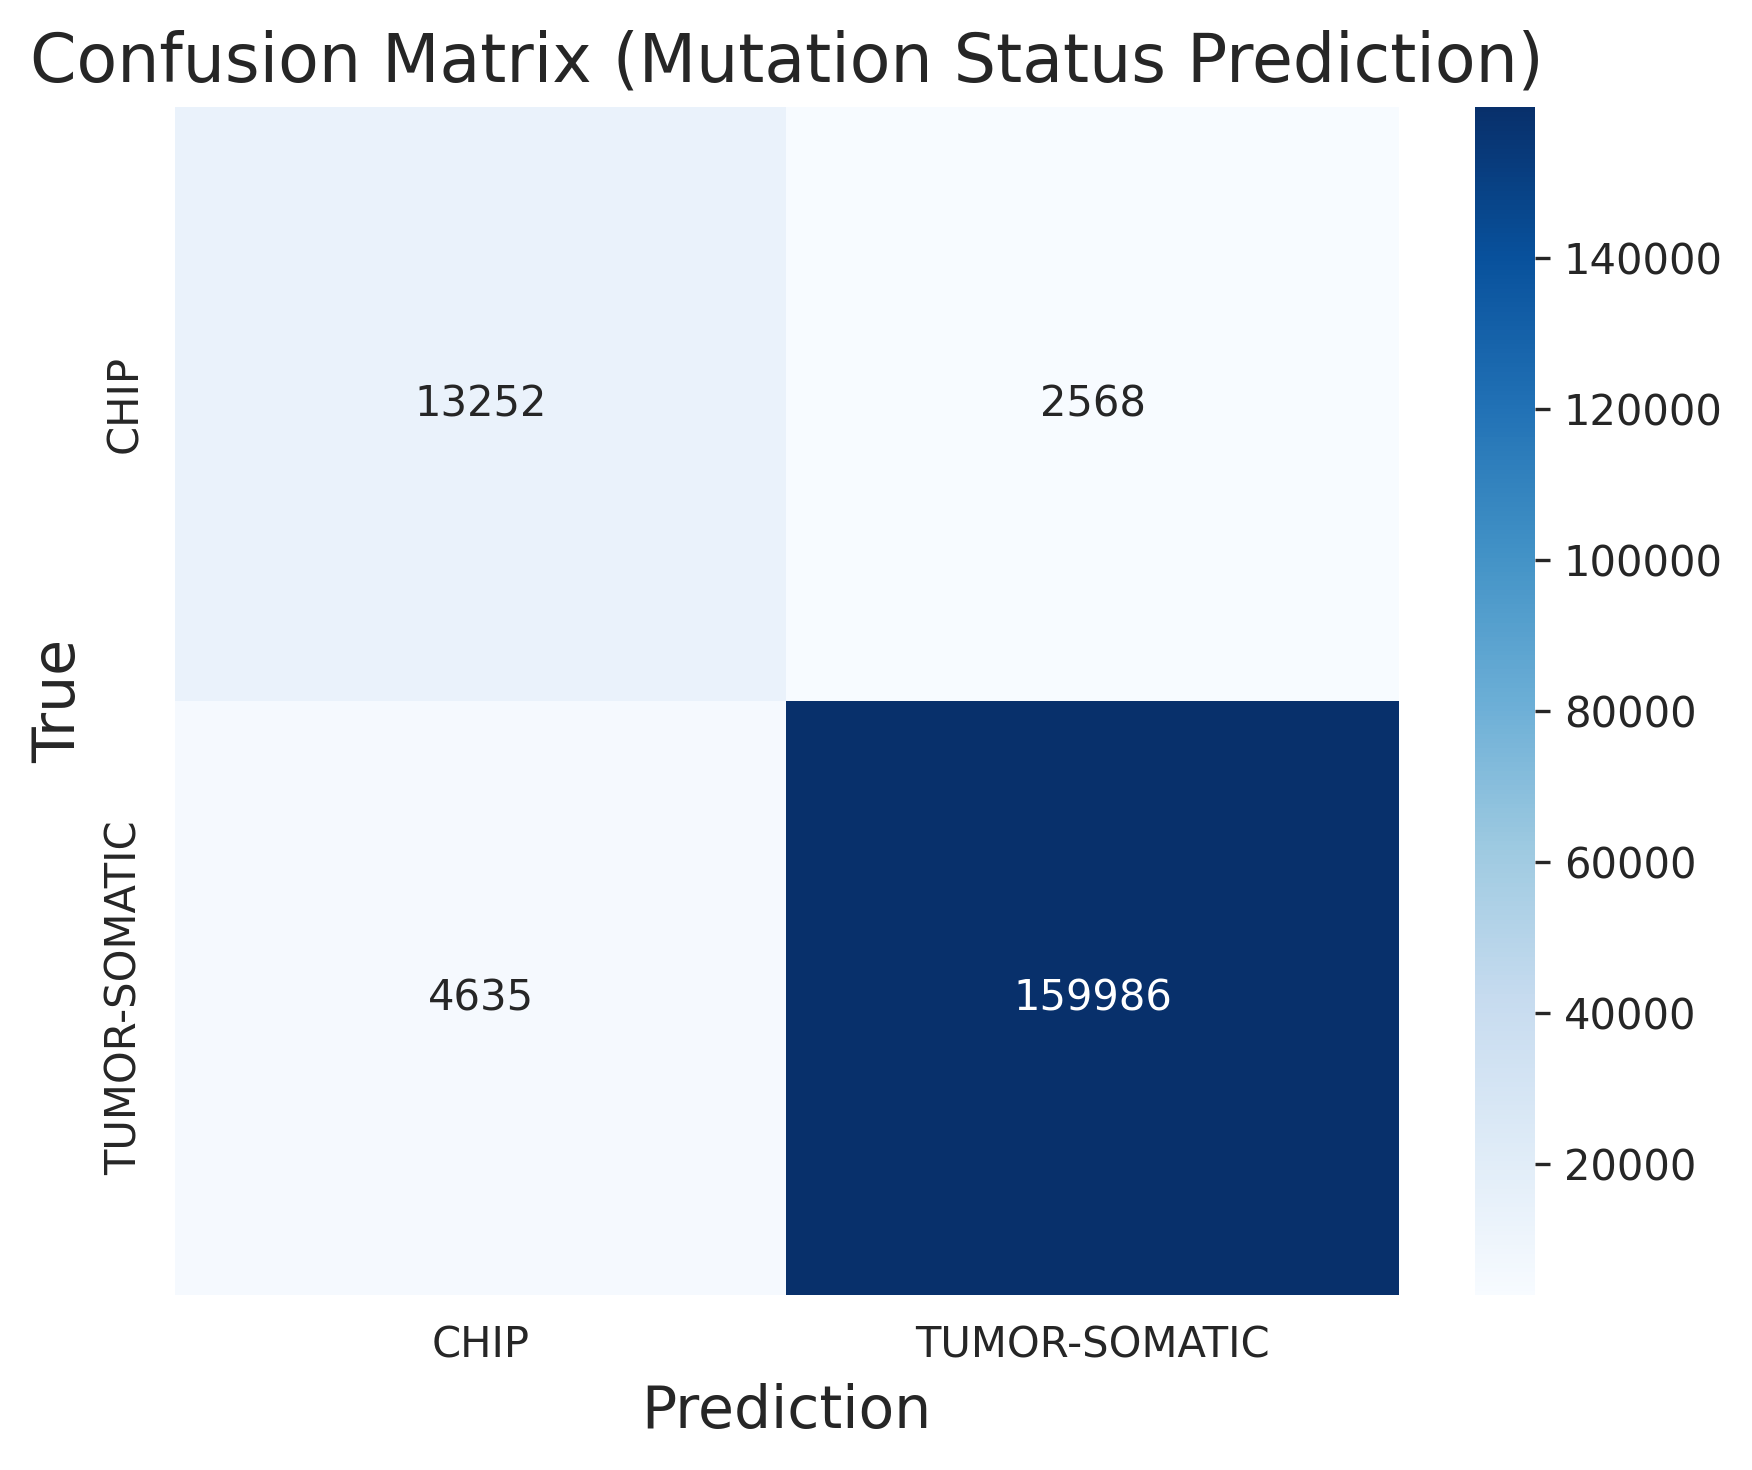


--- Normalized Confusion Matrix ---
                   CHIP  TUMOR-SOMATIC
CHIP           0.837674       0.162326
TUMOR-SOMATIC  0.028156       0.971844
locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7fff6f69c470>
Using auto colorbar locator <matplotlib.colorbar._ColorbarAutoLocator object at 0x7fff6f69c470> on colorbar
Setting pcolormesh


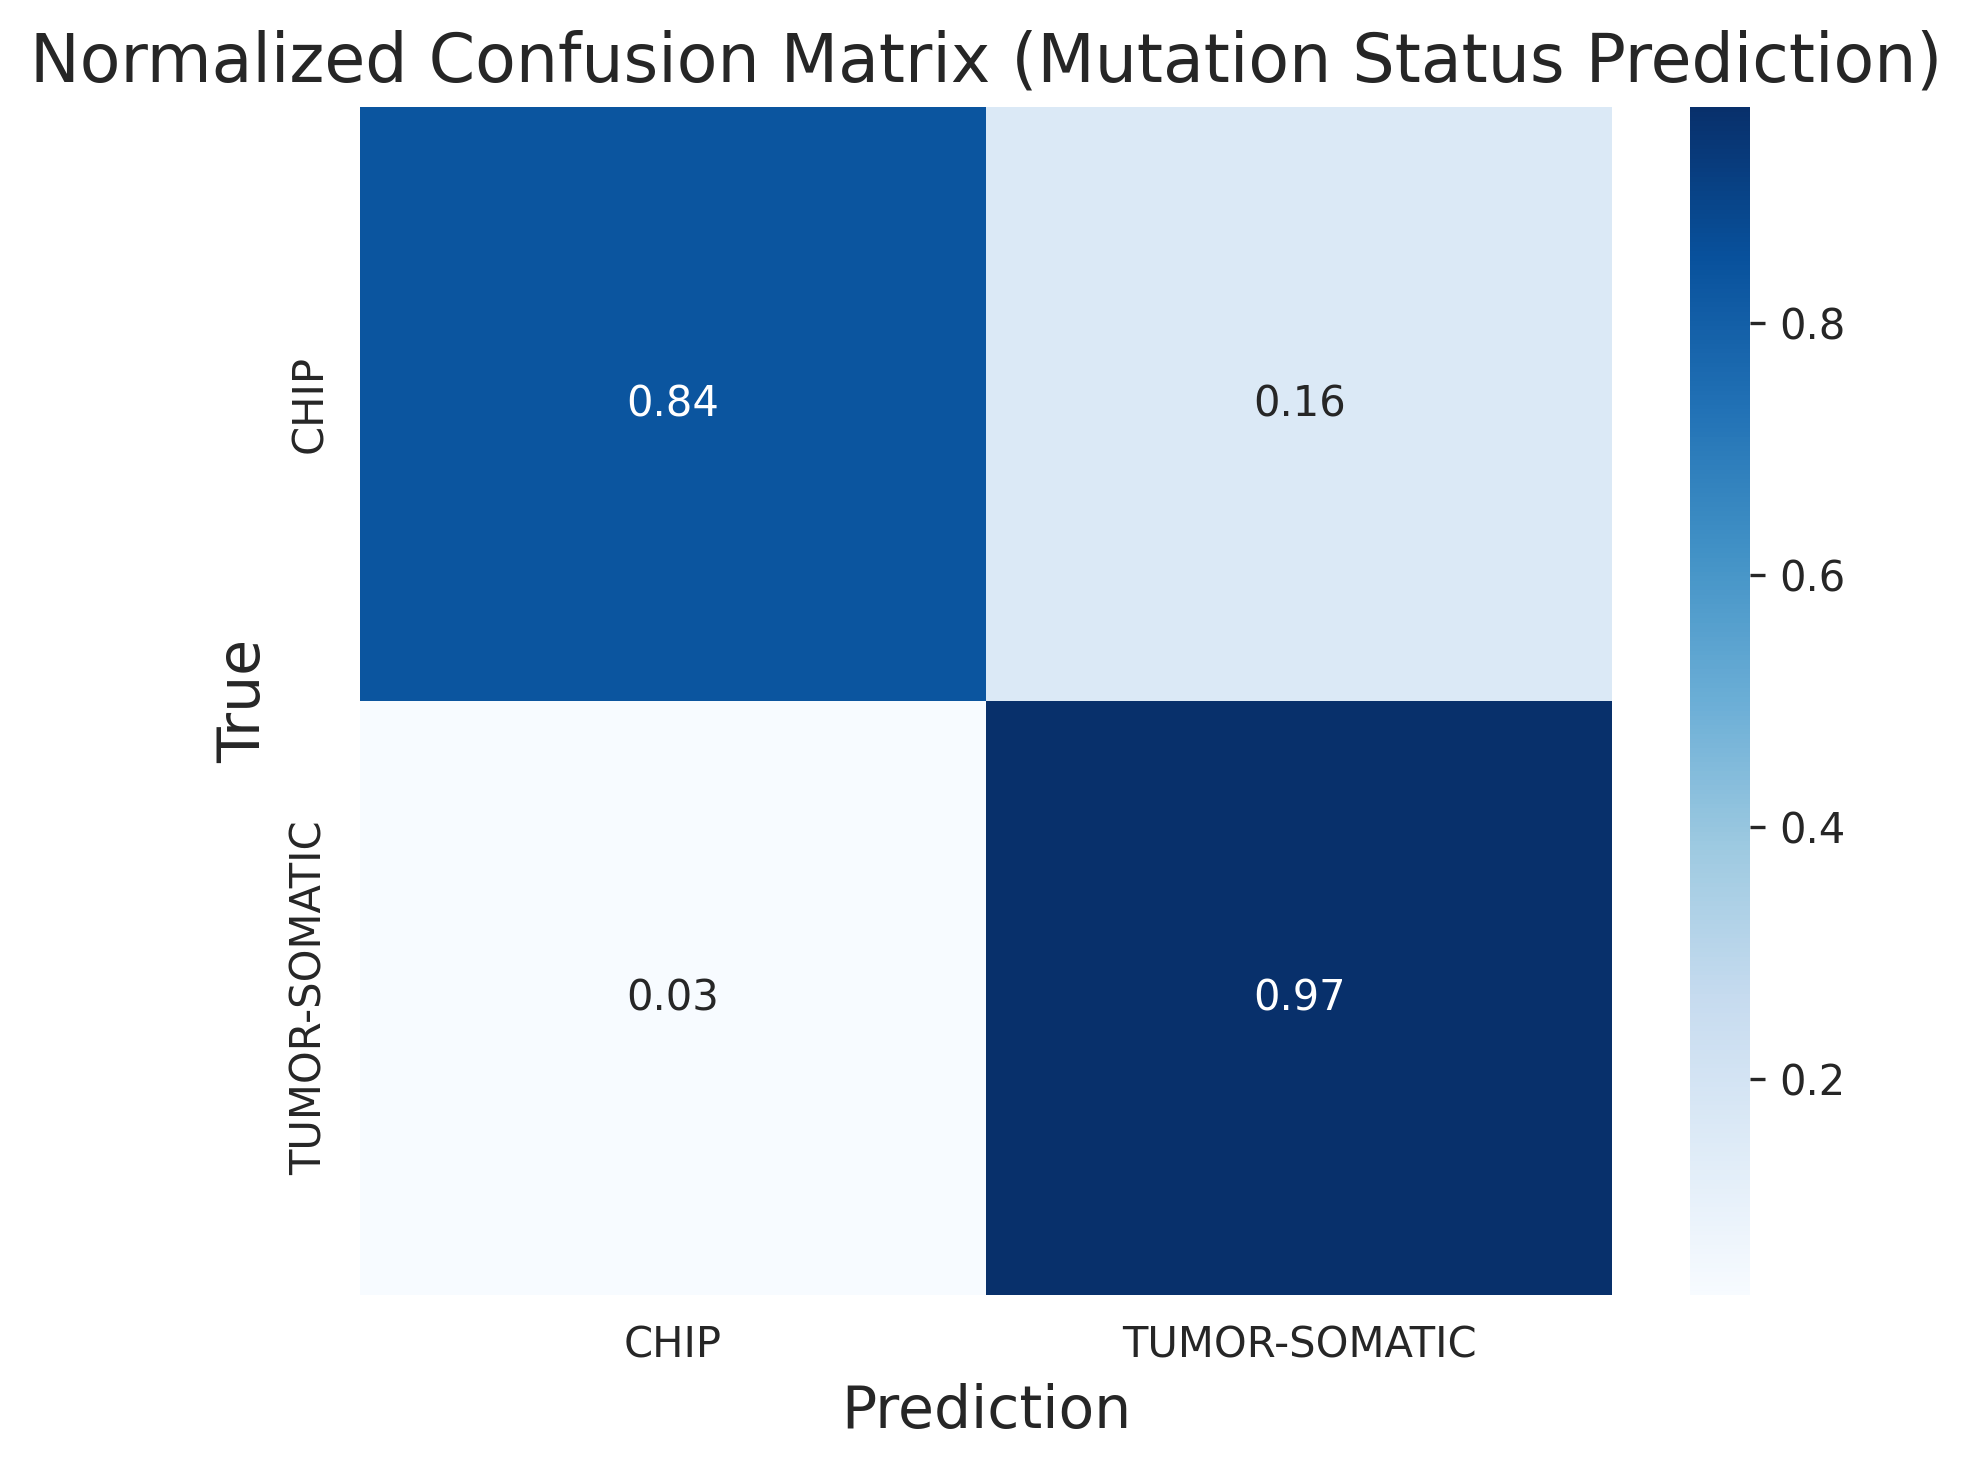

locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7fff33819a58>
Using auto colorbar locator <matplotlib.colorbar._ColorbarAutoLocator object at 0x7fff33819a58> on colorbar
Setting pcolormesh


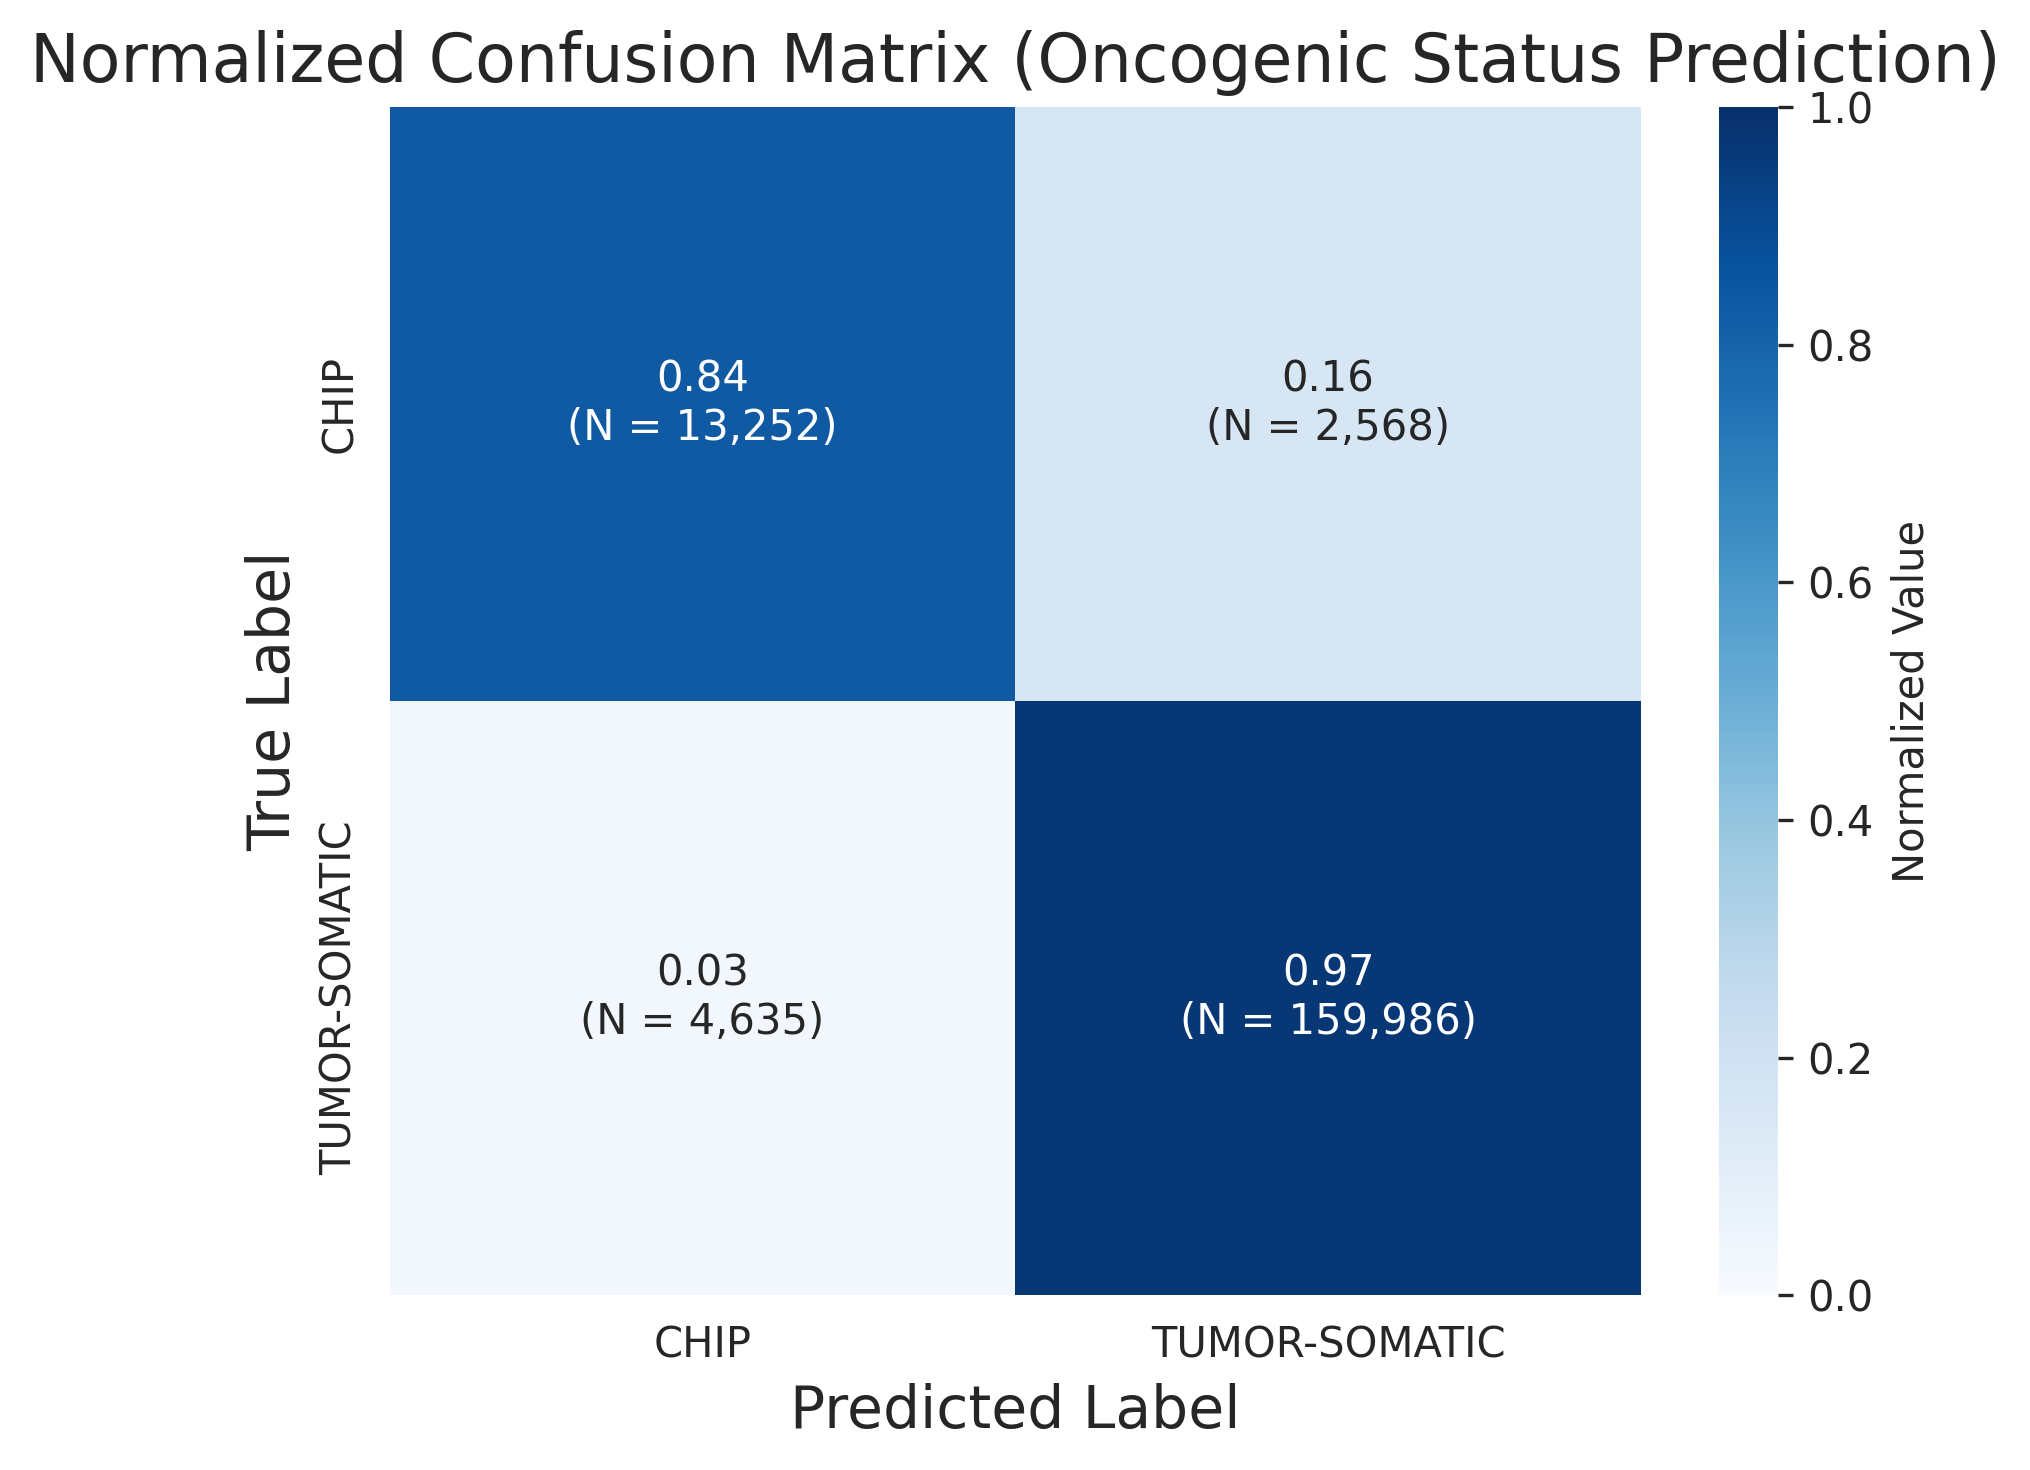

In [72]:

print("\n--- Confusion Matrix ---")
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred, labels=categories, normalize=None)
cm_df = pd.DataFrame(cm, 
                     index=categories,
                     columns=categories)
print(cm_df)

# Plot confusion matrix heatmap
plt.figure(figsize=(6, 5), dpi=300)
sns.heatmap(cm_df, annot=True, fmt="d", cmap="Blues", cbar=True)
plt.title("Confusion Matrix (Mutation Status Prediction)", fontsize=16)
plt.ylabel("True", fontsize=14)
plt.xlabel("Prediction", fontsize=14)
plt.tight_layout()
plt.show()


# Confusion Matrix (normalized by row)
cm = confusion_matrix(y_true, y_pred, labels=categories, normalize="true")
cm_df = pd.DataFrame(cm, 
                     index=categories,
                     columns=categories)

print("\n--- Normalized Confusion Matrix ---")
print(cm_df)

# Plot confusion matrix heatmap
plt.figure(figsize=(6, 5), dpi=300)
sns.heatmap(cm_df, annot=True, fmt=".2f", cmap="Blues", cbar=True)
plt.title("Normalized Confusion Matrix (Mutation Status Prediction)", fontsize=16)
plt.ylabel("True", fontsize=14)
plt.xlabel("Prediction", fontsize=14)
plt.tight_layout()
plt.show()

#==================COMBINED FIGURE================
# Set style
sns.set_style("white")

# Calculate confusion matrices
cm_raw = confusion_matrix(y_true, y_pred, labels=categories)
cm_norm = confusion_matrix(y_true, y_pred, labels=categories, normalize='true')

# Remove last row if needed (as in your original code)
# cm_raw = cm_raw[:-1, :]
# cm_norm = cm_norm[:-1, :]

# Create DataFrame for the heatmap (using normalized values for colors)
cm_df = pd.DataFrame(cm_norm, 
                     index=categories,
                     columns=categories)

# Create annotations with both normalized values and counts
annot = np.empty_like(cm_df, dtype=object)
for i in range(len(categories)):
    for j in range(len(categories)):
        annot[i, j] = f"{cm_norm[i, j]:.2f}\n(N = {cm_raw[i, j]:,})"

# Plot the combined confusion matrix
plt.figure(figsize=(6, 5), dpi=300)
sns.heatmap(cm_df, 
            annot=annot, 
            fmt="", 
            cmap="Blues", 
            cbar=True,
            vmin=0,
            vmax=1,
            cbar_kws={'label': 'Normalized Value'})

plt.title("Normalized Confusion Matrix (Oncogenic Status Prediction)", fontsize=16)
plt.ylabel("True Label", fontsize=14)
plt.xlabel("Predicted Label", fontsize=14)
plt.tight_layout()
plt.show()
